# Basic regression: Predict fuel efficiency
https://www.tensorflow.org/tutorials/keras/regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
seed = 21

# make printouts easier to read
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print("version", tf.__version__)
print("executing eagerly", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "not available")

version 2.3.0
executing eagerly True
GPU is available


In [2]:
# get the data The Auto MPG dataset

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [3]:
dataset = raw_dataset.copy()
print(dataset.shape)
dataset.tail()

(398, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# drop the nan
dataset = dataset.dropna().reset_index(drop=True)
dataset.shape

(392, 8)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 24.6 KB


In [7]:
dataset["Origin"] = dataset["Origin"].map({1:"USA", 2:"Europe",3:"Japan"})
dataset["Origin"].unique()

array(['USA', 'Japan', 'Europe'], dtype=object)

In [8]:
dataset = pd.get_dummies(dataset, prefix="", prefix_sep="")
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [9]:
# split into train and test
train_dataset = dataset.sample(frac=.8, random_state = seed)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

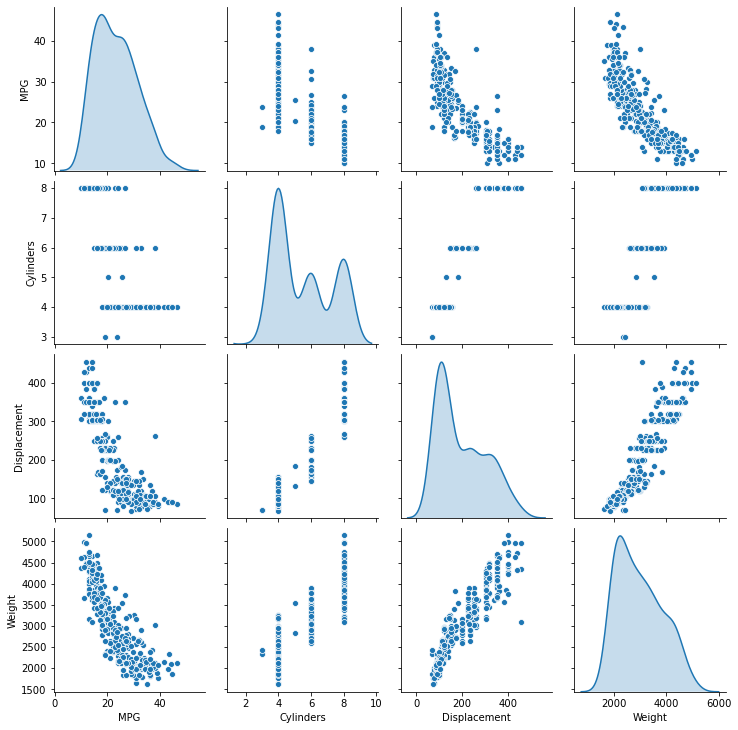

In [10]:
sns.pairplot(train_dataset[["MPG","Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.340446,7.798283,10.0,17.000,22.45,29.0,46.6
Cylinders,314.0,5.528662,1.705322,3.0,4.000,4.50,8.0,8.0
Displacement,314.0,197.864650,105.203781,68.0,105.000,153.50,302.0,455.0
Horsepower,314.0,104.576433,38.812265,46.0,75.000,95.00,129.0,230.0
Weight,314.0,2993.643312,857.043551,1613.0,2228.500,2861.50,3631.5,5140.0
Acceleration,314.0,15.511465,2.746627,8.0,13.925,15.50,17.0,24.8
Model Year,314.0,75.847134,3.741940,70.0,73.000,76.00,79.0,82.0
Europe,314.0,0.168790,0.375164,0.0,0.000,0.00,0.0,1.0
Japan,314.0,0.187898,0.391254,0.0,0.000,0.00,0.0,1.0
USA,314.0,0.643312,0.479786,0.0,0.000,1.00,1.0,1.0


In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

### why normalize the inputs

`It is good practice to normalize features that use different scales and ranges.
`

`One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
`

`Although a model might converge without feature normalization, normalization makes training much more stable.`

In [13]:
normalizer = Normalization()
normalizer.adapt(np.array(train_features))

In [14]:
print(normalizer.mean.numpy())

[   5.529  197.865  104.576 2993.643   15.511   75.847    0.169    0.188
    0.643]


In [15]:
first = train_features[:1]
np.array(first)

array([[   4. ,   90. ,   70. , 1937. ,   14.2,   76. ,    1. ,    0. ,
           0. ]])

In [16]:
normalizer(first).numpy()

array([[-0.898, -1.027, -0.892, -1.235, -0.478,  0.041,  2.219, -0.481,
        -1.343]], dtype=float32)

In [17]:
# build the model
model = Sequential([normalizer, 
                    Dense(64, activation='relu'),
                   Dense(64, activation='relu'),
                   Dense(1)])

model.compile(loss='mean_absolute_error',
             optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [18]:
history = model.fit(train_features, train_labels, 
                    epochs=100, validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 0s 14ms/step - loss: 22.5254 - val_loss: 24.1753
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 21.7941 - val_loss: 23.3841
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 20.9618 - val_loss: 22.4364
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 19.9465 - val_loss: 21.2216
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 18.6255 - val_loss: 19.6521
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 16.9399 - val_loss: 17.8958
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 15.2672 - val_loss: 16.1936
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 13.6757 - val_loss: 14.2531
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 11.9122 - val_loss: 11.7664
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 9.5423 - val_loss: 8.6567
Epoch 11/1

8/8 [==============================] - 0s 3ms/step - loss: 1.5406 - val_loss: 2.0605
Epoch 83/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5370 - val_loss: 2.0384
Epoch 84/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5228 - val_loss: 2.0502
Epoch 85/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5106 - val_loss: 2.0443
Epoch 86/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5477 - val_loss: 2.0641
Epoch 87/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5335 - val_loss: 2.0474
Epoch 88/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5167 - val_loss: 2.0389
Epoch 89/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5189 - val_loss: 2.0746
Epoch 90/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5090 - val_loss: 2.0533
Epoch 91/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5092 - val_loss: 2.0699
Epoch 92/100
8/8 [===============

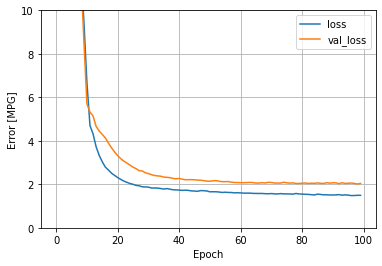

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

In [20]:
preds = model.predict(test_features).flatten()
preds

array([13.137, 12.68 , 10.245, 17.309, 26.542, 25.941, 27.16 , 13.176,
       13.067, 13.688, 25.906, 11.939, 17.489, 12.503, 26.901, 29.6  ,
       20.568, 23.313, 14.323, 21.362, 17.283, 16.599, 16.607, 14.418,
       25.741, 19.076, 15.634, 24.105, 26.427, 26.868, 14.745, 31.365,
       28.373, 14.714, 24.576, 32.317, 18.93 , 14.625, 15.366, 30.103,
       31.069, 29.271, 28.374, 23.79 , 28.567, 34.338, 16.687, 18.75 ,
       25.907, 16.513, 16.126, 27.585, 28.433, 23.766, 24.7  , 21.324,
       18.315, 32.62 , 25.721, 24.355, 33.861, 25.156, 32.241, 31.28 ,
       34.712, 30.69 , 34.093, 29.017, 32.383, 37.953, 35.492, 24.142,
       30.332, 27.88 , 34.755, 37.542, 41.773, 29.351], dtype=float32)

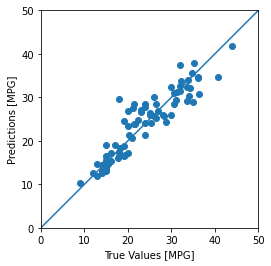

In [21]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, preds)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

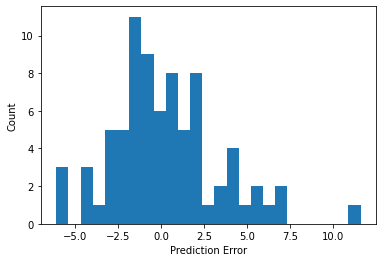

In [22]:
error = preds - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")